In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
import dask_jobqueue
from distributed import Client
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
#import seaborn as sns
#import gcsfs
import cftime
import pandas as pd
import xesmf as xe
#import xskillscoere as xs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cartopy as cart
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from shapely.geometry import Point

/tmp/ipykernel_90644/3090792.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [3]:
quants = np.linspace(0,1.0,30)

def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [4]:
chicago_LAT=41.88
chicago_LON=(360-87.6298)%360
#
# cvals = '/Users/hrh/Desktop/TwoMoments21/cvals/cmip6/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'

In [5]:
#job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="lr6", cores=20, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

In [6]:
cluster

Dashboard: http://10.0.2.2:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.2.2:37898,Workers: 0
Dashboard: http://10.0.2.2:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat        = ds[get_lat_name(ds)]
    weight     = np.cos(np.deg2rad(lat))
    weight    /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [17]:
ds_pi_det  = xr.open_zarr(cvals+'cmip6_pi_quantiles_ann_detrended.zarr').tasmax
ds_eoc_det = xr.open_zarr(cvals+'cmip6_eoc_quantiles_ann_detrended.zarr').tasmax
ds_eoc_det

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-9da3ab4af43611d86b60dff4ab857fb3tasmax, shape=(18, 30, 365, 61, 121), dtype=float64, chunksize=(1, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [9]:
################################################### Land and Ocean -only curves #######################

In [10]:
def is_land(lon, lat):
  
   # Adjust the longitude from 0-360 to -180-180
    if lon > 180:
        lon -= 360
   # Create a Natural Earth Reader
    land_shp_fname = shpreader.natural_earth(resolution='110m', category='physical', name='land')
    # Load the shapefile using Shapely's shape() function
    land_geom = [geom for geom in shpreader.Reader(land_shp_fname).geometries()]
    # Check if the point is within any land geometry
    return any([geom.contains(Point(lon, lat)) for geom in land_geom])

In [11]:
def create_land_mask(ds):
    """Create a land mask for a given xarray dataset."""
    
    # Get the latitude and longitude points from the dataset
    lats = ds['lat'].values
    lons = ds['lon'].values

    # Create an empty mask with the same shape as the data
    land_mask = np.empty((len(lats), len(lons)))

    # Fill the mask using the is_land function
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            land_mask[i, j] = is_land(lon, lat)

    # Create a new DataArray with the land mask
    ds_land_mask = xr.DataArray(land_mask, coords=[lats, lons], dims=['lat', 'lon'])

    # # Add the land mask to the dataset and return
    # ds['land_mask'] = ds_land_mask
    return ds_land_mask

In [18]:
%%time
pi_land_mask   = create_land_mask(ds_pi_det)
eoc_land_mask  = create_land_mask(ds_eoc_det)
eoc_land_mask

CPU times: user 20min 7s, sys: 49.5 s, total: 20min 56s
Wall time: 20min 22s


<xarray.DataArray (lat: 61, lon: 121)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon      (lon) int64 0 3 6 9 12 15 18 21 ... 339 342 345 348 351 354 357 360

In [13]:
#land_mask

In [16]:
# %%time
# ax       = plt.axes(projection=cart.crs.PlateCarree())
# eoc_land_mask.plot(ax=ax,transform=cart.crs.PlateCarree())
# # plt.plot(-87.629,41.94,marker='*',color='tab:orange')
# # plt.plot(77.5,12.72,marker='*',color='tab:brown')
# ax.coastlines(color="black")
# plt.title('Land Mask')
# plt.show()

In [19]:
%%time
pi_land   = final_ds_pi.where(pi_land_mask==1)
eoc_land  = final_ds_eoc.where(eoc_land_mask==1)
pi_ocean  = final_ds_pi.where(pi_land_mask==0)
eoc_ocean = final_ds_eoc.where(eoc_land_mask==0)
eoc_ocean

CPU times: user 61.8 ms, sys: 7.07 ms, total: 68.9 ms
Wall time: 63.3 ms


<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<where, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [20]:
%%time
## Save masked arrays
pi_land.to_dataset().to_zarr(cvals+'cmip6_pi_land.zarr',mode='w')
pi_ocean.to_dataset().to_zarr(cvals+'cmip6_pi_ocean.zarr',mode='w')
eoc_ocean.to_dataset().to_zarr(cvals+'cmip6_eoc_ocean.zarr',mode='w')
eoc_land.to_dataset().to_zarr(cvals+'cmip6_eoc_land.zarr',mode='w')

CPU times: user 45.7 s, sys: 3.37 s, total: 49 s
Wall time: 51.4 s


In [21]:
pi_land   = xr.open_zarr(cvals+'cmip6_pi_land.zarr').tasmax
pi_ocean  = xr.open_zarr(cvals+'cmip6_pi_ocean.zarr').tasmax
eoc_land  = xr.open_zarr(cvals+'cmip6_eoc_land.zarr').tasmax
eoc_ocean = xr.open_zarr(cvals+'cmip6_eoc_ocean.zarr').tasmax

In [22]:
qeoc_land   = compute_quantiles(eoc_land)
qpi_land    = compute_quantiles(pi_land)
qeoc_ocean  = compute_quantiles(eoc_ocean)
qpi_ocean   = compute_quantiles(pi_ocean)
qano_land   = qeoc_land - qpi_land
qano_ocean  = qeoc_ocean - qpi_ocean
qano_ocean

<xarray.DataArray 'tasmax' (quantile: 30, source_id: 18, dayofyear: 365,
                            lat: 61, lon: 121)>
dask.array<sub, shape=(30, 18, 365, 61, 121), dtype=float64, chunksize=(30, 3, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [23]:
# %%time
# # #Save anomalies 
# qano_land.to_dataset().to_zarr(cvals+'cmip6_qano_annual_land.zarr',mode='w')
# qano_ocean.to_dataset().to_zarr(cvals+'cmip6_qano_annual_ocean.zarr',mode='w')

CPU times: user 56.1 s, sys: 3.79 s, total: 59.9 s
Wall time: 1min


In [24]:
%%time
qano_land   = xr.open_zarr(cvals+'cmip6_qano_annual_land.zarr').tasmax
qano_ocean  = xr.open_zarr(cvals+'cmip6_qano_annual_ocean.zarr').tasmax
qano_std_land    = qano_land.std('source_id')
qano_std_ocean   = qano_ocean.std('source_id')
qano_std_aomean  = global_mean(qano_std_ocean)
qano_std_almean  = global_mean(qano_std_land)
qano_std_aomean

CPU times: user 130 ms, sys: 28.4 ms, total: 158 ms
Wall time: 150 ms


<xarray.DataArray (quantile: 30)>
dask.array<mean_agg-aggregate, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [25]:
%%time
qano_std_almean = qano_std_almean.rename('tasmax_qanomaly')
qano_std_aomean = qano_std_aomean.rename('tasmax_qanomaly')
# qano_std_almean.to_dataset().to_zarr(cvals+'cmip6_quantiles_ano_land_mean.zarr',mode='w')
# qano_std_aomean.to_dataset().to_zarr(cvals+'cmip6_quantiles_ano_ocean_mean.zarr',mode='w')

CPU times: user 15.1 s, sys: 1.19 s, total: 16.3 s
Wall time: 21.2 s


In [26]:
qano_std_almean = xr.open_zarr(cvals+'cmip6_quantiles_ano_land_mean.zarr').tasmax_qanomaly
qano_std_aomean = xr.open_zarr(cvals+'cmip6_quantiles_ano_ocean_mean.zarr').tasmax_qanomaly
qano_std_almean 

<xarray.DataArray 'tasmax_qanomaly' (quantile: 30)>
dask.array<open_dataset-76fb6ab7bf51e8bee8883ba08dc76a3btasmax_qanomaly, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

(0.0, 1.0)

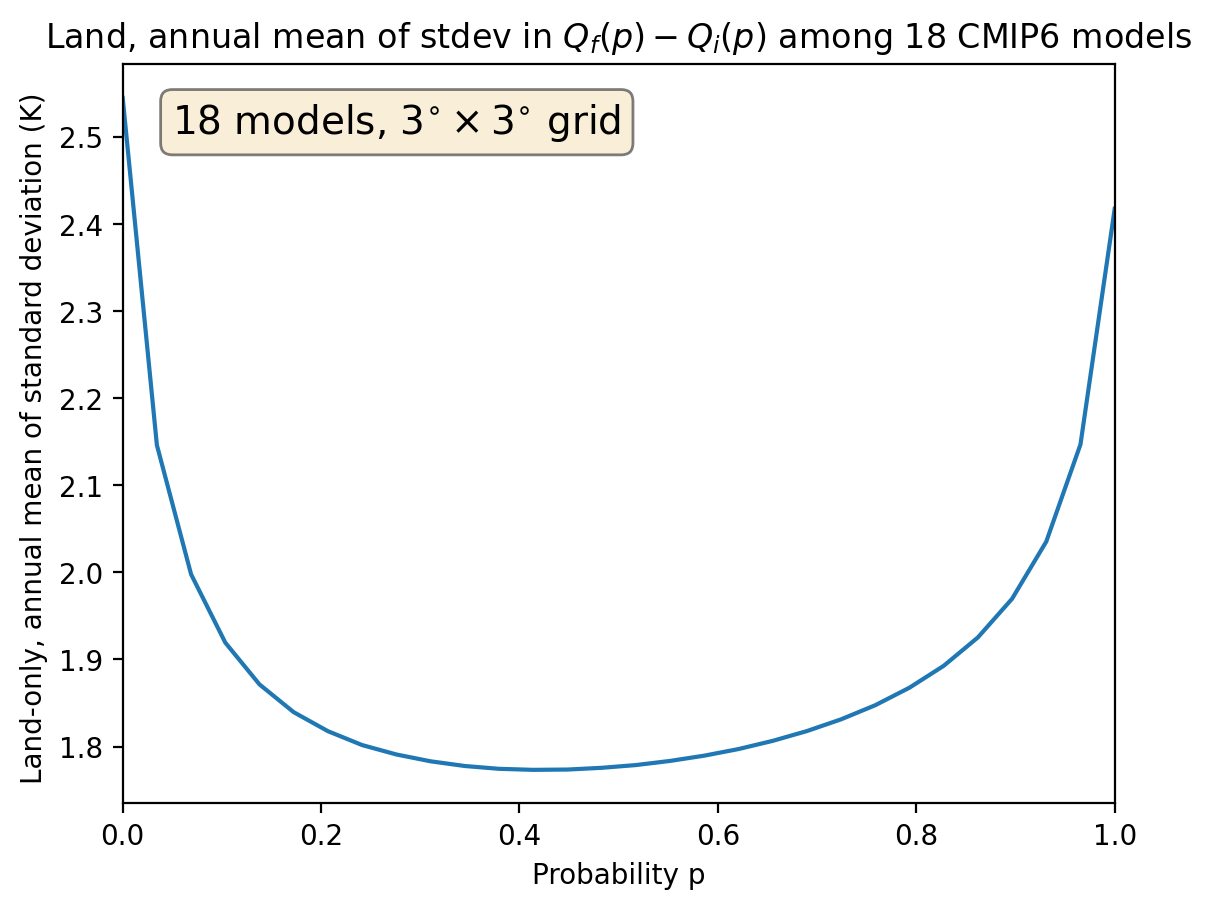

In [27]:
qano_std_almean.plot()
plt.xlabel('Probability p')
plt.ylabel('Land-only, annual mean of standard deviation (K) ')
plt.title(r'Land, annual mean of stdev in $Q_f(p) -Q_i(p)$ among 18 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.ylim(0,1.8)
plt.xlim(0,1.0)

(0.0, 1.0)

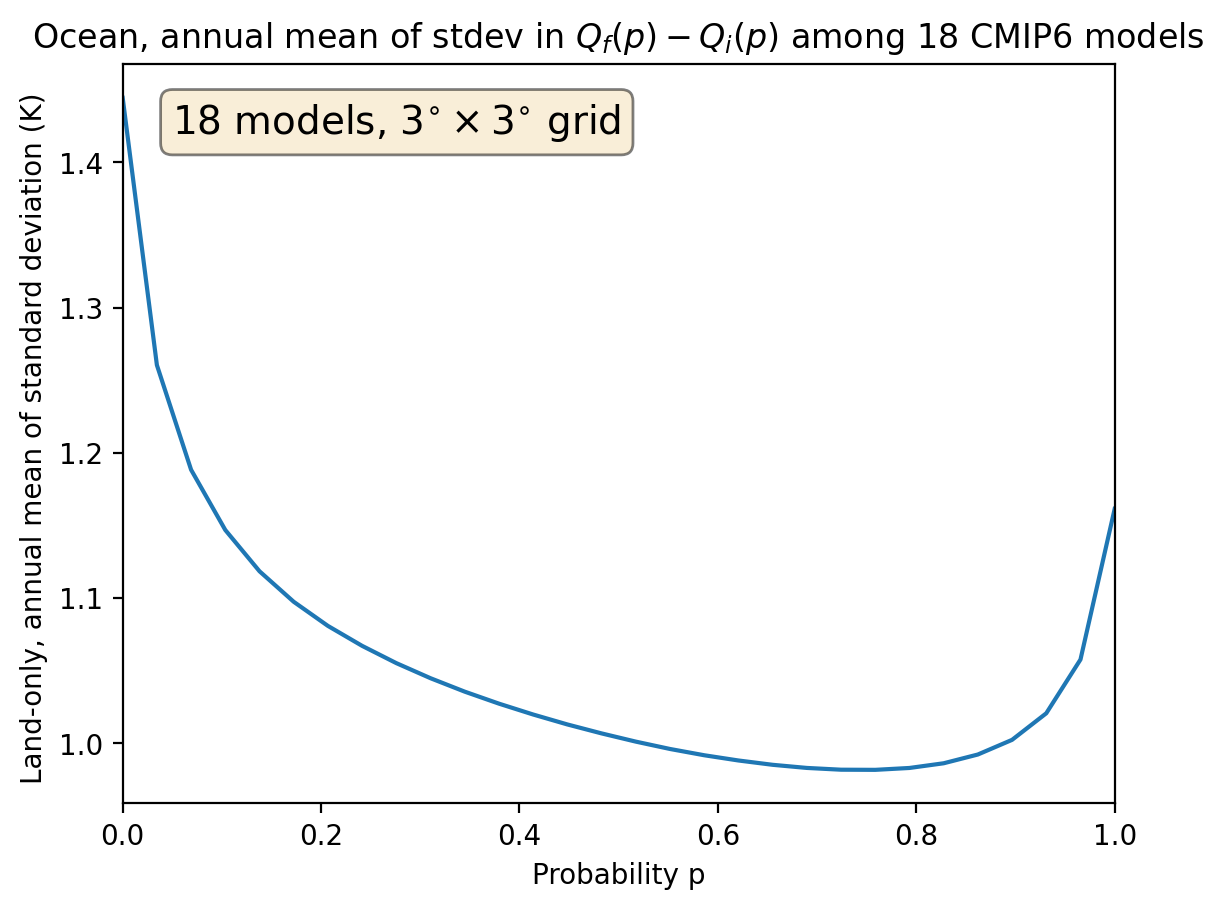

In [28]:
qano_std_aomean.plot()
plt.xlabel('Probability p')
plt.ylabel('Land-only, annual mean of standard deviation (K) ')
plt.title(r'Ocean, annual mean of stdev in $Q_f(p) -Q_i(p)$ among 18 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.ylim(0,1.8)
plt.xlim(0,1.0)